In [95]:
import re
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pprint import pprint
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})


hatches = ['o', '*', '\\\\', 'O', 'x', '\\', '--', 'o']
markers = ['o', '*', "^"]
linestyles = ['dashdot', 'solid', '--']
orig_colors = sns.color_palette("colorblind")
colors = [
    orig_colors[2],
    orig_colors[4],
    orig_colors[0],
    orig_colors[1],
]
FWD_TIME_COLOR = orig_colors[7]
BWD_TIME_COLOR = orig_colors[8]
STEP_TIME_COLOR = orig_colors[9]
GPU_PER_NODE = 4
num_steps = 10
models = [
            {'n': 1, 'm': 3, 'H': 2560, 'F': 11008, 'N': 30, 'L': 32, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 45}, 
            {'n': 2, 'm': 7, 'H': 4096, 'F': 11008, 'N': 32, 'L': 32, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 83}, 
            {'n': 4, 'm': 13, 'H': 5120, 'F': 13824, 'N': 40, 'L': 40, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 166}, 
            {'n': 8, 'm': 30, 'H': 6656, 'F': 17920, 'N': 60, 'L': 52, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 444}, 
            {'n': 20, 'm': 70, 'H': 8192, 'F': 28672, 'N': 80, 'L': 64, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 16, 'ckpt_size': 1065},
            {'n': 70, 'm': 175, 'H': 14336, 'F': 28672, 'N': 70, 'L': 112, 'U': 2048, 'S': 4, 'K': 5, 'mbs': 8, 'ckpt_size': 2754},
]
DEFAULT_DEEPSPEED = "DeepSpeed ZeRO-3"
PARTLY_OPTIMIZED = "Deep Optimizer States (only backpass)"
FULLY_OPTIMIZED = "Deep Optimizer States"

approach_code = {
    DEFAULT_DEEPSPEED: 0,
    PARTLY_OPTIMIZED: 1,
    FULLY_OPTIMIZED: 2
}
base_config = {"basepath":"./", "approach": DEFAULT_DEEPSPEED, "dp": 1, "tp": 1, "ga": 1, "tf_ratio":1, 
                "act_ckpt":True, "mbs": 4, "gbs": 4, "subg": int(100*1e6), "opt_gaps": 5, "num_steps": 10}
df_columns = [
    'elapsed_time_per_iteration_ms', 
    'iter_time',
    'samples_per_second', 
    'TFLOPs', 
    'fwd', 
    'bwd', 
    'step',
    'bwd_inner_microstep', 
    'bwd_allreduce_microstep', 
    'step_microstep'
]

def parse_log(m, c):
    is_prefetch = 1 if c['approach'] == FULLY_OPTIMIZED else 0
    is_async = 1 if c['approach'] in (PARTLY_OPTIMIZED, FULLY_OPTIMIZED)  else 0
    log_file = (
            f"{c['basepath']}/log-{m['m']}B-tp{c['tp']}-dp{c['dp']}-l{m['N']}-h{m['H']}-a{m['L']}-sl{m['U']}-"
            f"gbs{c['gbs']}-mbs{c['mbs']}-ratio{c['tf_ratio']}-subg{c['subg']}-prefetch{is_prefetch}-"
            f"flush_async{is_async}-opt_gaps{c['opt_gaps']}.log"
    )
#     print(f"Reading {log_file}")       
    data = {k: [] for k in df_columns}
    with open(log_file, 'r') as file:
        for line in file:
            match = re.findall(r'<TIMER:interval-time,(\d+\.\d+)>', line)
            for x in match:
                data['iter_time'].append(float(x))
            
            match = re.search(r'elapsed time per iteration \(ms\): (\d+\.\d+)', line)
            if match:
                data['elapsed_time_per_iteration_ms'].append(float(match.group(1)))

            match = re.search(r'samples per second: (\d+\.\d+)', line)
            if match:
                data['samples_per_second'].append(float(match.group(1)))

            match = re.search(r'TFLOPs: (\d+\.\d+)', line)
            if match:
                data['TFLOPs'].append(float(match.group(1)))

            match = re.search(r'fwd: (\d+\.\d+)', line)
            if match:
                data['fwd'].append(float(match.group(1)))

            match = re.search(r'bwd: (\d+\.\d+)', line)
            if match:
                data['bwd'].append(float(match.group(1)))
            
            match = re.search(r'\|\s*step: (\d+\.\d+)', line)
            if match:
                data['step'].append(float(match.group(1)))

            match = re.search(r'bwd_inner_microstep: (\d+\.\d+)', line)
            if match:
                data['bwd_inner_microstep'].append(float(match.group(1)))

            match = re.search(r'bwd_allreduce_microstep: (\d+\.\d+)', line)
            if match:
                data['bwd_allreduce_microstep'].append(float(match.group(1)))

            match = re.search(r'step_microstep: (\d+\.\d+)', line)
            if match:
                data['step_microstep'].append(float(match.group(1)))

    if c['dp'] > 1: # This is used only because every rank is printing `interval-time`
        k = c['dp']
        num_entries = len(data['iter_time']) // k
        iter_times = [sum(data['iter_time'][i*k:(i+1)*k]) / k for i in range(num_entries)]
        data['iter_time'] = iter_times
    df = pd.DataFrame(data, columns=df_columns)
    
    # We would have 10 values, select the last 5 of them
    df = df.tail(4)
    return df

def get_avg(arr):
    return sum(arr)/len(arr)


[0 1 2]


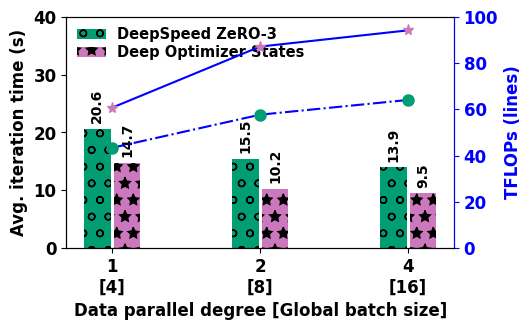

In [97]:
###############################################################
# Plot for increasing DP
###############################################################

def plot_scale_DP(m, config, data):
    output_file = f"./plots/{m['m']}B-scale-DP"

    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.2
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    print(xrange)
    offset = -0.5
    iter_time = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        iter_time[blabel] = [get_avg(data[glabel][blabel]['elapsed_time_per_iteration_ms'])/1e3 for glabel in group_labels]
        ax.bar(xrange + offset * bar_width, iter_time[blabel], bar_width+bar_gap, label=f'Bar {blabel}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = -0.5
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 1), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_xlabel('Data parallel degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg. iteration time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=40)
    if m['m'] == 7:
        ax.set_ylim(top=20)
    ax.set_xticklabels([f"{x}\n[{x*config['mbs']}]" for i, x in enumerate(group_labels)])
    
    # Plot the TFLOPs on secondary y-axis
    tflops = {}
    for i, blabel in enumerate(bar_labels):
        tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
        ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
                 markersize=8, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    ax2.spines['right'].set_color('blue')
    ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    ax2.set_ylim(bottom=0, top=100)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, bar_labels, ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.2, ) 
    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# Parse log for 7B and/or 13B models for varying DP values
m = list(filter(lambda x: x.get('m') == 13, models))[0]
config = copy.deepcopy(base_config)
res_scale_dp = {}
for dp in [1, 2, 4]:
    config['basepath'] = f"./act-output-{m['m']}B-scale-DP"
    config['dp'] = dp
    config['gbs'] = config['mbs']*dp
    config['approach'] = DEFAULT_DEEPSPEED
    df_default = parse_log(m, config)
    config['approach'] = PARTLY_OPTIMIZED
    df_partly = parse_log(m, config)
    config['approach'] = FULLY_OPTIMIZED
    df_fully = parse_log(m, config)
    res_scale_dp[dp] = {DEFAULT_DEEPSPEED: df_default, 
#                         PARTLY_OPTIMIZED: df_partly, 
                        FULLY_OPTIMIZED: df_fully}

plot_scale_DP(m, config, res_scale_dp)

/tmp/ipykernel_12516/2559112903.py:75: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


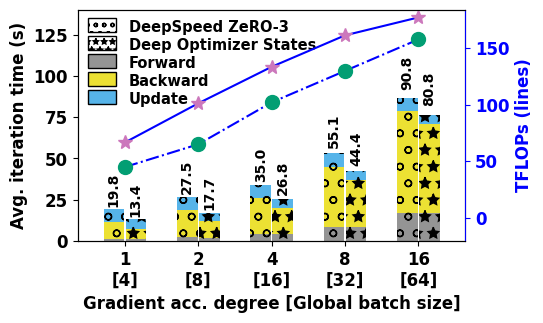

In [98]:

###############################################################
# Plot for increasing GA
###############################################################
def plot_scale_GA(m, config, data):
    output_file = f"./plots/{m['m']}B-scale-GA"

    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    offset = -0.5
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        ax.bar(xrange, np.zeros(len(xrange)), label=blabel, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
        fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
        bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
        step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = -0.5
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 1), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Avg. iteration time (s)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=140)
    if m['m'] == 7:
        ax.set_ylim(top=75)
    ax.set_xticklabels([f"{x}\n[{x*config['mbs']}]" for i, x in enumerate(group_labels)])
    
    # Plot the TFLOPs on secondary y-axis
    tflops = {}
    for i, blabel in enumerate(bar_labels):
        tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
        ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
                 markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    ax2.spines['right'].set_color('blue')
    ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3] # Legend for only number of approches + 3 (fwd, bwd, update)
    legends = ax.legend(handles, labels, ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.2, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

# Parse log for 7B and/or 13B models for varying GA values
m = list(filter(lambda x: x.get('m') == 13, models))[0]
config = copy.deepcopy(base_config)
res_scale_ga = {}
for ga in [1, 2, 4, 8, 16]:
    config['basepath'] = f"./act-output-{m['m']}B-scale-GA-single-GPU"
    config['ga'] = ga
    config['gbs'] = config['mbs']*ga
    config['approach'] = DEFAULT_DEEPSPEED
    df_default = parse_log(m, config)
    config['approach'] = PARTLY_OPTIMIZED
    df_partly = parse_log(m, config)
    config['approach'] = FULLY_OPTIMIZED
    df_fully = parse_log(m, config)
    res_scale_ga[ga] = {DEFAULT_DEEPSPEED: df_default, 
#                         PARTLY_OPTIMIZED: df_partly, 
                        FULLY_OPTIMIZED: df_fully}

plot_scale_GA(m, config, res_scale_ga)
